In [1]:
import os

import numpy as np 
print(np.version.version)
import pandas as pd 

import pickle

import itertools 

from eli5 import show_prediction, show_weights
from eli5.sklearn import PermutationImportance

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import xgboost as xgb 
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import seaborn as sns 

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

import sys
sys.path.append('..')

from inxai import *
import shap
import lime


import logging

from ConfigSpace.hyperparameters import UniformFloatHyperparameter

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from smac.facade.smac_bo_facade import SMAC4BO
# Import SMAC-utilities
from smac.scenario.scenario import Scenario


1.20.0


Possible set intersection at position 3


# 1. Helper functions

In [2]:
path = '../examples/'

def to_pickle(obj, name):
    with open(path + name + '.pickle', 'wb') as f:
        pickle.dump(obj, f)

def from_pickle(name):
    return pd.read_pickle(path + name + '.pickle')


In [3]:
## Nie uzywam stacking-ensemble poniewaz potrzebuje miec kontrole nad wagami gdy lacze modele
## Interesuje mnie srednia wazona z predykcji 3 modeli 

class weighted_model:
    '''
    Wrapper for classificators to combine up to 3 models.
    Weights are always scaled to sum up to 1 (or 100%). 
    '''
    def __init__(self, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None):
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.colnames = None
        
    def predict(self, X):
        weighted_proba = self.predict_proba(X)
        return [0 if wp[0] > 0.5 else 1 for wp in weighted_proba]
    
    def predict_proba(self, X):
        w_ = self.w1 + self.w2 + self.w3
        m2_predict_proba = 0.0 if self.w2 == 0.0 else self.m2.predict_proba(X)
        m3_predict_proba = 0.0 if self.w3 == 0.0 else self.m3.predict_proba(X)
        weighted_prediction = (self.w1 * self.m1.predict_proba(X) + self.w2 * m2_predict_proba + self.w3 * m3_predict_proba) / w_
        return weighted_prediction

    def fit(self, X):
        self.colnames = X.columns
        return self


In [55]:
def approximateAreaUnderTheCurveAccLoss(acc_loss): 
    acc_los_abs = [0 if value < 0 else value for value in acc_loss]
    return sum(acc_los_abs) / len(acc_los_abs)

def AreaUnderTheCurveAccLoss(acc_loss):
    l = len(acc_loss)
    return auc(np.linspace(0, 1, l), acc_loss)

In [7]:
def weighted_shap_naive(w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None):
    '''
    Use this as a fast approximation 
    '''
    w_ = w1 + w2 + w3
    
    shapNone = [shap_i * 0.0 for shap_i in shap1]
    
    shap1_w = [shap_i * w1 for shap_i in shap1]
    shap2_w = shapNone if w2 == 0.0 else [shap_i * w2 for shap_i in shap2]
    shap3_w = shapNone if w3 == 0.0 else [shap_i * w3 for shap_i in shap3]
    
    shap_zip =  zip(shap1_w, shap2_w, shap3_w)
    
    return [(shap1_w_i + shap2_w_i + shap3_w_i) / w_ for shap1_w_i, shap2_w_i, shap3_w_i in shap_zip]


In [ ]:
def weighted_acc_loss(X_test, y_test, ct, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, plot=True):
#     print("debug-1")
    weighted_perm = PermutationImportance(weighted_model(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3), random_state=42, scoring="accuracy").fit(X_test, y_test)
#     print("debug-2")
    weighted_perm_importances = weighted_perm.feature_importances_
    show_weights(weighted_perm, feature_names=FEATURE_IDS)
    
    return gm.gradual_perturbation(model = weighted_model(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3), X = X_test, y = y_test, column_transformer = ct, importances_orig = weighted_perm_importances, resolution=50,  count_per_step=10, plot=plot)

def weighted_acc_loss_auc_naive(w1, auc1, w2 = 0.0, auc2 = None, w3 = 0.0, auc3 = None):
    '''
    Use this as a fast approximation 
    '''
    return (w1 * auc1 + w2 * auc2 + w3 * auc3) / (w1 + w2 + w3)

In [8]:
def weighted_stability(X_test, w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None):
    w_shap_ensemble_naive = weighted_shap_naive(w1=w1, shap1=shap1, w2=w2, shap2=shap2, w3=w3, shap3=shap3)
    return gm.stability(X_test, w_shap_ensemble_naive, epsilon=0.3)

def weighted_stability_naive(w1, stability1, w2 = 0.0, stability2 = None, w3 = 0.0, stability3 = None):
    '''
    Use this as a fast approximation of weighted_stability
    '''
    stability1None = np.array(stability1) * 0.0
    
    stability1_w =  np.array(stability1) * w1
    stability2_w = stability1None if w2 == 0.0 else  np.array(stability2) * w2
    stability3_w = stability1None if w3 == 0.0 else  np.array(stability3) * w3

    return np.array(stability1 + stability2 + stability3) / (w1 + w2 + w3)


In [9]:
def weighted_consistency_naive(w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None):
    '''
    Use this as a fast approximation 
    '''
    w_ = w1 + w2 + w3
    
    shapNone = [shap_i * 0.0 for shap_i in shap1]
    
    shap1_w = [shap_i * w1 / w_ for shap_i in shap1]
    shap2_w = shapNone if w2 == 0.0 else [shap_i * w2 / w_ for shap_i in shap2]
    shap3_w = shapNone if w3 == 0.0 else [shap_i * w3 / w_ for shap_i in shap3]

    return gm.consistency([shap1_w,  shap2_w, shap3_w])


# 2. CompassRecividism data

In [10]:
df = pd.read_csv("../examples/data/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")
# print(df.shape)
# display(df.columns)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0
5,0,3,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0,0,0,0
8,1,3,1,0,1,1,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1,1


In [11]:
TARGET_COL = "Two_yr_Recidivism"

X = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

FEATURE_IDS = [str(i) for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)

# print("TRAIN:")
# print(X_train.head())
# print("\nTEST:")
# print(y_test.head())

# 3.Classificators 
- svc_radial
- svc_lin
- xgbc
- lgbm
- rfc
- catboost

In [12]:
svc_radial = SVC(kernel='rbf',probability=True) # does not work with eli

svc_radial.fit(X_train, y_train)
svc_radial_preds = svc_radial.predict(X_test)

# to_pickle(svc_radial, 'model_svc_radial')

print(accuracy_score(y_test, svc_radial_preds))
print(classification_report(y_test, svc_radial_preds))

# show_prediction(svc_radial, X_train.iloc[1], feature_names = X.columns.tolist(), 
#                 show_feature_values=True)

0.658321060382916
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1118
           1       0.63      0.60      0.61       919

    accuracy                           0.66      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.66      0.66      0.66      2037



In [13]:
svc_lin = SVC(kernel='linear',probability=True) 
svc_lin.fit(X_train, y_train)
svc_lin_preds = svc_lin.predict(X_test)

# to_pickle(svc_lin, 'model_svc_lin')

print(accuracy_score(y_test, svc_lin_preds))
print(classification_report(y_test, svc_lin_preds))

show_prediction(svc_lin, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6514482081492391
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1118
           1       0.61      0.61      0.61       919

    accuracy                           0.65      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.65      0.65      0.65      2037



In [14]:
xgbc = xgb.XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_preds = xgbc.predict(X_test)

# to_pickle(xgbc, 'model_xgbc')

print(accuracy_score(y_test, xgbc_preds))
print(classification_report(y_test, xgbc_preds))

show_prediction(xgbc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:31:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6666666666666666
              precision    recall  f1-score   support

           0       0.69      0.73      0.70      1118
           1       0.64      0.60      0.62       919

    accuracy                           0.67      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037



In [15]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4 }

lgbm = lgb.train(params,                                    # does not work with eli
                 lgb.Dataset(X_train,label=y_train),
#                  2500,
                 valid_sets=lgb.Dataset(X_test,label=y_test),
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

lgbm_preds = lgbm.predict(X_test)
lgbm_preds = (lgbm_preds > 0.5) * 1

# to_pickle(lgbm, 'model_lgbm')

print(accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# show_prediction(lgbm, X_train.iloc[1], feature_names = X.columns.tolist(), #estimator is not supported
#                 show_feature_values=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 11
[LightGBM] [Info] Start training from score 0.457074
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.720958
0.678939617083947
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1118
           1       0.68      0.54      0.60       919

    accuracy                           0.68      2037
   macro avg       0.68      0.67      0.67      2037
weighted avg       0.68      0.68      0.67      2037



In [16]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

# to_pickle(rfc, 'model_rfc')

print(accuracy_score(y_test, rfc_preds))
print(classification_report(y_test, rfc_preds))

show_prediction(rfc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6627393225331369
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1118
           1       0.64      0.59      0.61       919

    accuracy                           0.66      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.66      0.66      0.66      2037



In [17]:
ctbc = CatBoostClassifier(
#     custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    iterations=1000, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

ctbc.fit(X_train, y_train)
ctbc_preds = ctbc.predict(X_test)

# to_pickle(ctbc, 'model_ctbc')

print(accuracy_score(y_test, ctbc_preds))
print(classification_report(y_test, ctbc_preds))

# show_prediction(ctbc, X_train.iloc[1], feature_names = X.columns.tolist(),  #estimator is not supported
#                 show_feature_values=True)

0.6681394207167403
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1118
           1       0.64      0.59      0.62       919

    accuracy                           0.67      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037



## read models from pickle's

In [18]:
svc_radial = from_pickle('model_svc_radial')
svc_lin = from_pickle('model_svc_lin')
xgbc = from_pickle('model_xgbc')
lgbm = from_pickle('model_lgbm')
rfc = from_pickle('model_rfc')
ctbc = from_pickle('model_ctbc')


# 4. Local explanations

## LIME values 
- fix by reset of index

In [ ]:
X_test_copy = X_test.copy().reset_index(drop=True)
y_test_copy = y_test.copy().reset_index(drop=True)

lime_svc_radial = generate_per_instance_importances(models=[svc_radial], X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_svc_radial, 'lime_svc_radial')
print(lime_svc_radial)

lime_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_svc_lin, 'lime_svc_lin')
print(lime_svc_lin)

lime_xgbc = generate_per_instance_importances(models=xgbc, X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_xgbc, 'lime_xgbc')
print(lime_xgbc)

lime_lgbm = generate_per_instance_importances(models=lgbm, X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_lgbm, 'lime_lgbm')
print(lime_lgbm)

lime_rfc = generate_per_instance_importances(models=rfc, X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_rfc, 'lime_rfc')
print(lime_rfc)

lime_ctbc = generate_per_instance_importances(models=ctbc, X=X_test_copy, y=y_test_copy, framework='lime') # does not work 
to_pickle(lime_ctbc, 'lime_ctbc')
print(lime_ctbc)

### LIME's baseline

In [ ]:
## 
lime_svc_radial = from_pickle('lime_svc_radial')
print(len(lime_svc_radial))

lime_svc_lin = from_pickle('lime_svc_lin')
print(len(lime_svc_lin))

## 
lime_xgbc = from_pickle('lime_xgbc')
print(len(lime_xgbc))

lime_lgbm = from_pickle('lime_lgbm')
print(len(lime_lgbm))

lime_rfc = from_pickle('lime_rfc')
print(len(lime_rfc))

lime_ctbc = from_pickle('lime_ctbc')
print(len(lime_ctbc))


## SHAP values

### SHAP's baseline

In [161]:
## took to long - only sample
shap_svc_radial = from_pickle('shap_svc_radial')
print(len(shap_svc_radial))

shap_svc_lin = from_pickle('shap_svc_lin')
print(len(shap_svc_lin))

## OK
shap_xgbc = from_pickle('shap_xgbc')
print(len(shap_xgbc))

shap_rfc = from_pickle('shap_rfc')
print(len(shap_rfc))

shap_ctbc = from_pickle('shap_ctbc')
print(len(shap_ctbc))


10
10
2037
2037
2037


### SHAP combined - not used

In [ ]:
shap_tree_xgbc_rfc_ctbc = generate_per_instance_importances(models=[xgbc, rfc, ctb], X=X_test, y=y_test, framework='tree_shap') 
to_pickle(shap_tree_xgbc_rfc_ctbc, 'shap_tree_xgbc_rfc_ctbc')
# shap_tree_xgbc_rfc_ctbc = from_pickle('shap_tree_xgbc_rfc_ctbc')
len(shap_tree_xgbc_rfc_ctbc)

### Consistency pairwaise

In [25]:
shap_xgbc_rfc_consistency = gm.consistency([shap_xgbc, shap_rfc])
shap_xgbc_ctbc_consistency = gm.consistency([shap_xgbc, shap_ctbc])
shap_rfc_ctbc_consistency = gm.consistency([shap_rfc, shap_ctbc])

<AxesSubplot:xlabel='variable', ylabel='value'>

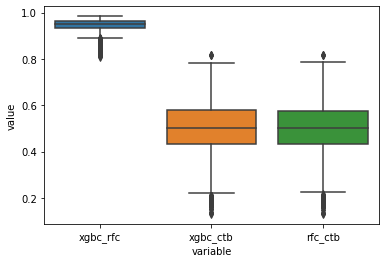

In [27]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'xgbc_rfc':shap_xgbc_rfc_consistency, 'xgbc_ctbc':shap_xgbc_ctbc_consistency, 'rfc_ctbc':shap_rfc_ctbc_consistency})))

#### ctbc - nie wiem co jest nie tak z tym modelem???

In [28]:
shap_ctbc

array([[ 2.39407675e+00,  1.34827256e-01,  4.01103883e-01, ...,
         2.42115840e-02, -4.26372272e-02,  2.66641666e-01],
       [-4.13366225e-01, -3.32472050e-01,  5.92306932e-02, ...,
         1.77403141e-02,  1.38035209e-01, -1.89828915e-01],
       [-6.55980584e-02, -3.04260272e-01,  1.16450630e-01, ...,
        -1.92433356e-03,  6.87979727e-02,  1.19939049e-01],
       ...,
       [-1.58041456e+00, -5.78112129e-01,  3.39171233e-01, ...,
        -5.54854959e-04,  1.11809266e-01, -1.08686274e+00],
       [-1.00953821e+00, -1.48709467e-01,  2.12694907e-01, ...,
         1.63617496e-02, -5.73304972e-01, -2.14285338e-01],
       [ 2.25344983e-01,  5.02799881e-01,  8.29515521e-02, ...,
        -2.24592645e-02,  7.93258055e-02,  9.33522223e-02]])

### Stability per model

In [36]:
shap_xgbc_stability = from_pickle('shap_xgbc_stability')
shap_rfc_stability = from_pickle('shap_rfc_stability')
shap_ctbc_stability = from_pickle('shap_ctbc_stability')


<AxesSubplot:xlabel='variable', ylabel='value'>

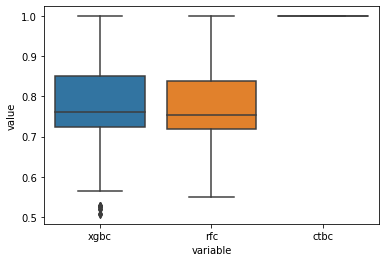

In [38]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'xgbc':shap_xgbc_stability,'rfc':shap_rfc_stability,'ctbc':shap_ctbc_stability})))

#### ctbc - nie wiem co jest nie tak z tym modelem???

<AxesSubplot:xlabel='variable', ylabel='value'>

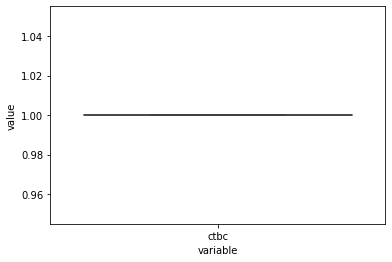

In [39]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'ctbc':shap_ctbc_stability})))

### Area under the accuracy loss

In [40]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),X_test.columns)])

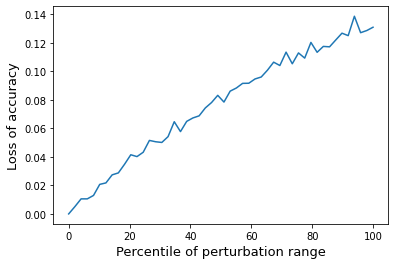

In [42]:
## takes a long time
acc_loss_xgbc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = xgbc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None)
to_pickle(acc_loss_xgbc, 'acc_loss_xgbc')

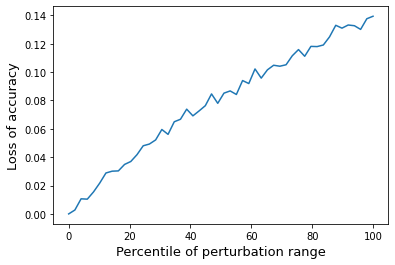

In [44]:
## takes a long time
acc_loss_rfc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = rfc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None)
to_pickle(acc_loss_rfc, 'acc_loss_rfc')

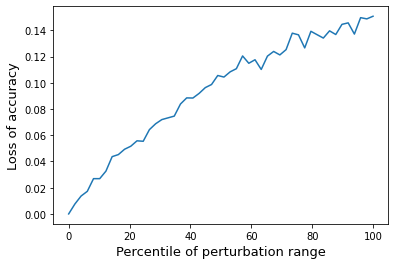

In [45]:
## takes a long time
acc_loss_ctbc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = ctbc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None)
to_pickle(acc_loss_ctbc, 'acc_loss_ctbc')

In [46]:
acc_loss_xgbc = from_pickle('acc_loss_xgbc')
acc_loss_rfc = from_pickle('acc_loss_rfc')
acc_loss_ctbc = from_pickle('acc_loss_ctbc')

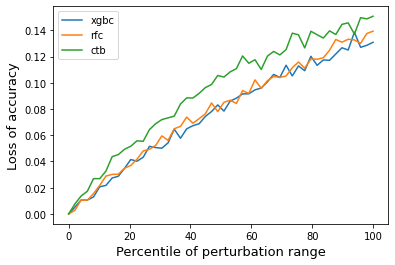

In [50]:
plt.plot(np.linspace(0, 100, 50), acc_loss_xgbc)
plt.plot(np.linspace(0, 100, 50), acc_loss_rfc)
plt.plot(np.linspace(0, 100, 50), acc_loss_ctbc)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['xgbc','rfc','ctb'])

In [64]:
print(approximateAreaUnderTheCurveAccLoss(acc_loss_xgbc))
xgbc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_xgbc)
print(xgbc_auc_acc_loss)

print(approximateAreaUnderTheCurveAccLoss(acc_loss_rfc))
rfc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_rfc)
print(rfc_auc_acc_loss)

print(approximateAreaUnderTheCurveAccLoss(acc_loss_ctbc))
ctbc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_ctbc)
print(ctbc_auc_acc_loss)

0.07618753068237606
0.07640637993046995
0.07855768286696126
0.07873824050975325
0.09350220913107515
0.09387153977938743


# 5. Weighted model 

## Weights from SHAP
- intial weights = norm of SHAP values; those are absolute values, does not scale to 100%
- ctbc - strange value ???

In [58]:
w_xgbc = 1 / np.mean([np.linalg.norm(x) for x in shap_xgbc])
w_rfc = 1 / np.mean([np.linalg.norm(x) for x in shap_rfc])
w_ctbc = 1 / np.mean([np.linalg.norm(x) for x in shap_ctbc])

print(w_xgbc, w_rfc, w_ctbc)

5.397124401075258 5.099577064644699 0.8977608069731127


### weighted model examples

In [60]:
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc).predict_proba(X_test)[0])
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc).predict(X_test)[0])

[0.05778992 0.94221008]
1


In [61]:
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=0.0, m3=None).predict_proba(X_test)[0])
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=0.0, m3=None).predict(X_test)[0])

[0.05942164 0.94057836]
1


### weighted AUC for Accuracy Loss
- accurate method

0.07578672116858524


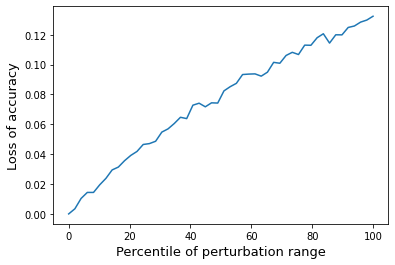

In [67]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),X_test.columns)])

weighted_xgbc_rfc_ctbc_acc_loss = weighted_acc_loss(X_test, y_test, ct, w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc)
to_pickle(weighted_xgbc_rfc_ctbc_acc_loss, "weighted_xgbc_rfc_ctbc_acc_loss")
print(AreaUnderTheCurveAccLoss(weighted_xgbc_rfc_ctbc_acc_loss))

- approximate method
- convernce with accurate method varies between runs

In [68]:
weighted_acc_loss_auc_naive(w1=w_xgbc, auc1=xgbc_auc_acc_loss, w2=w_rfc, auc2=rfc_auc_acc_loss, w3=w_ctbc, auc3=ctbc_auc_acc_loss)

0.07882606750045867

### weighted SHAP values

In [69]:
weighted_xgbc_rfc_ctbc_shap_naive = weighted_shap_naive(w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc)

### weighted stability

In [71]:
shap_xgbc_stability = from_pickle('shap_xgbc_stability')
shap_rfc_stability = from_pickle('shap_rfc_stability')
shap_ctbc_stability = from_pickle('shap_ctbc_stability')

#### ctbc - coś źle - same 1.0 

In [72]:
shap_ctbc_stability 

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [75]:
weighted_xgbc_rfc_ctb_stability = from_pickle('weighted_xgbc_rfc_ctb_stability')
weighted_xgbc_rfc_ctbc_stability

[1.0,
 0.8253883162676235,
 0.8420957139090727,
 0.7282067124467801,
 0.6982485321677769,
 0.7935823967479194,
 0.8108455240349902,
 1.0,
 0.8226603460794415,
 1.0,
 0.7013453740136073,
 0.7093913755645938,
 1.0,
 0.7665976491821465,
 0.6856459775617361,
 0.7771687144372744,
 0.7820625963926022,
 1.0,
 0.7013453740136073,
 0.8400142618171063,
 0.7587146233778237,
 0.6753752291573895,
 0.7013453740136073,
 1.0,
 1.0,
 1.0,
 0.6694044666307691,
 0.7343316485414316,
 0.7471120121175133,
 0.7787702162435116,
 0.7168343662650623,
 0.724529664838752,
 0.8983620751289262,
 0.7175034047334825,
 1.0,
 0.8587363876338734,
 0.8229269626266211,
 0.8077299019669587,
 0.6652612626917462,
 1.0,
 0.8860502467640401,
 1.0,
 0.7471120121175133,
 0.716918286749272,
 0.773830610362936,
 0.7089118952735946,
 0.6114415592627696,
 0.7553797757467395,
 0.6114415592627696,
 0.7754893341781516,
 0.8229269626266211,
 1.0,
 0.6893449205296132,
 0.7093913755645938,
 1.0,
 1.0,
 0.8027136937681159,
 0.6601390076754

In [76]:
weighted_stability_naive(w1=w_xgbc, stability1=shap_xgbc_stability, w2=w_rfc, stability2=shap_rfc_stability, w3=w_ctbc, stability3=shap_ctbc_stability)

array([0.08776193, 0.07265992, 0.07452551, ..., 0.08776193, 0.08776193,
       0.08776193])

### weighted consistency

In [79]:
shap_weighted_xgbc_rfc_ctbc_consistency = weighted_consistency_naive(w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc) 
to_pickle(shap_weighted_xgbc_rfc_ctbc_consistency, 'shap_weighted_xgbc_rfc_ctbc_consistency')
shap_weighted_xgbc_rfc_ctbc_consistency

[0.9411089281377116,
 0.9028206525467484,
 0.9202689831773498,
 0.8427737986429278,
 0.8170994383814989,
 0.8864008796219203,
 0.9769471240330143,
 0.8980238157099695,
 0.9800214493278122,
 0.8701590973772043,
 0.8282236188513392,
 0.9690675336936173,
 0.9728959856443454,
 0.879962310275013,
 0.8152764771608333,
 0.8764115388513753,
 0.880439259277589,
 0.9315291090998362,
 0.9799646273671256,
 0.9756572225266056,
 0.8670528010740317,
 0.9738956516595484,
 0.9799646273671256,
 0.825523030255932,
 0.6081628906358458,
 0.9313017174600942,
 0.9643042535679918,
 0.8375082325182707,
 0.8517667990417531,
 0.9672965096997862,
 0.9685185499247949,
 0.842898424300571,
 0.9512948704738293,
 0.836405223209772,
 0.8775652047294501,
 0.9229746897642133,
 0.9081488612039377,
 0.8970726526199002,
 0.8035103036335435,
 0.8599528362635254,
 0.9459934750820695,
 0.8775652047294501,
 0.8517667990417531,
 0.8427016968596805,
 0.9683796748379452,
 0.9657382148607183,
 0.922542827015252,
 0.9795661853725499

# 6. SMAC 

From examples
- https://automl.github.io/SMAC3/master/examples/SMAC4BO_rosenbrock.html#sphx-glr-examples-smac4bo-rosenbrock-py 
- https://automl.github.io/SMAC3/master/examples/SMAC4HPO_rosenbrock.html#sphx-glr-examples-smac4hpo-rosenbrock-py

## Optimizing weighted model = xgbc + rfc (we exclude ctbc).
## Firstly we use SHAP values. 

In [142]:
def exact_joint_metrics(x, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
    w_xgbc = x["w0"]
    w_rfc = x["w1"] if "w1" in x else 0.0
    w_ctbc = x["w2"] if "w2" in x else 0.0
    print(f'w_xgbc={w_xgbc}, w_rfc={w_rfc}, w_ctbc={w_ctbc}')
    
    w_acc_loss = weighted_acc_loss(X_test[:], y_test[:], ct, w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc)
    w_auc_acc_loss = AreaUnderTheCurveAccLoss(w_acc_loss)
    
    w_stability = weighted_stability(X_test[:], w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc)
    w_stability_m = np.median(w_stability)
    
    w_consistency = weighted_consistency_naive(w_xgbc, shap_xgbc[:], w_rfc, shap_rfc[:], w_ctbc, shap_ctbc[:])
    w_consistency_m = np.median(w_consistency)
    
    joint_metric = pow(w_auc_acc_loss, importance_auc_acc_loss) / (pow(w_stability_m, importance_stability) * pow(w_consistency_m, importance_consistency))
    
    print(f'AUC_acc_loss={w_auc_acc_loss}, stability={w_stability_m}, consistency={w_consistency_m}, joint_metric={joint_metric}')
    
    return {'auc_acc_loss' : w_auc_acc_loss, 'stability' : w_stability_m, 'consistency' : w_consistency_m, 'joint_metric' : joint_metric, 'w_xgbc' : w_xgbc, 'w_rfc' : w_rfc, 'w_ctbc' : w_ctbc}

def optimize_joint_metrics(x, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
    w_xgbc = x["w0"]
    w_rfc = x["w1"] if "w1" in x else 0.0
    w_ctbc = x["w2"] if "w2" in x else 0.0
    
    print(f'w_xgbc={w_xgbc}, w_rfc={w_rfc}, w_ctbc={w_ctbc}')

    
#     w_acc_loss = weighted_acc_loss(X_test[10:20], y_test[10:20], ct, w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, plot=False)
#     w_auc_acc_loss = AreaUnderTheCurveAccLoss(w_acc_loss)
    w_auc_acc_loss = weighted_acc_loss_auc_naive(w1=w_xgbc, auc1=xgbc_auc_acc_loss, w2=w_rfc, auc2=rfc_auc_acc_loss, w3=w_ctbc, auc3=ctbc_auc_acc_loss)

#     w_stability = weighted_stability(X_test[0:10], w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc)
    w_stability = weighted_stability_naive(w1=w_xgbc, stability1=shap_xgbc_stability, w2=w_rfc, stability2=shap_rfc_stability, w3=w_ctbc, stability3=shap_ctbc_stability)
    w_stability_m = np.median(w_stability)

#     w_consistency = weighted_consistency_naive(w_xgbc, shap_xgbc[0:10], w_rfc, shap_rfc[0:10], w_ctbc, shap_ctbc[0:10])
    w_consistency = weighted_consistency_naive(w_xgbc, shap_xgbc, w_rfc, shap_rfc, w_ctbc, shap_ctbc)
    w_consistency_m = np.median(w_consistency)
    
    joint_metric = pow(w_auc_acc_loss, importance_auc_acc_loss) / (pow(w_stability_m, importance_stability) * pow(w_consistency_m, importance_consistency))
    
    print(f'AUC_acc_loss={w_auc_acc_loss}, stability={w_stability_m}, consistency={w_consistency_m}, joint_metric={joint_metric}')
    
    return joint_metric


In [143]:
def run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
    logging.basicConfig(level=logging.INFO)  # logging.DEBUG for debug output

    # Build Configuration Space which defines all parameters and their ranges
    cs = ConfigurationSpace()

    x0 = UniformFloatHyperparameter("w0", 0, 10, default_value=w_xgbc)
    x1 = UniformFloatHyperparameter("w1", 0, 10, default_value=w_rfc)
    # x2 = UniformFloatHyperparameter("w2", 0, 100, default_value=w_ctbc) # ctbc - wylaczam ten model z ekeperymentu 
    # cs.add_hyperparameters([x0, x1, x2])
    cs.add_hyperparameters([x0, x1])

    # Scenario object
    scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternatively runtime)
                         "runcount-limit": 30,  # max. number of function evaluations; for this example set to a low number
                         "cs": cs,  # configuration space
                         "deterministic": "true",
                         "abort_on_first_run_crash": "true"
                         })

    # Example call of the function
    # It returns: Status, Cost, Runtime, Additional Infos
    def_value = optimize_joint_metrics(cs.get_default_configuration(), importance_auc_acc_loss = importance_auc_acc_loss, importance_stability = importance_stability, importance_consistency = importance_consistency)
    print("Default Value: %.2f" % def_value)

    # Optimize, using a SMAC-object
    print("Optimizing! Depending on your machine, this might take a few minutes.")
    smac = SMAC4BO(scenario=scenario,
                   rng=np.random.RandomState(42),
                   tae_runner=optimize_joint_metrics,
                   )

    cfg = smac.optimize()
    
    return {k: cfg[k] for k in cfg if cfg[k]}


### Wszystkie eksperymenty zbiegaja sie do tych samych wag {w_xgbc, w_rfc}  

In [153]:
# importance_auc_acc_loss = importance_stability = importance_consistency = 1.0
e1 = run_experiment()
r1 = exact_joint_metrics(e1, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0)
to_pickle(r1, 'r1')
r1

{'auc_acc_loss': 0.07291535170769338,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.10687357496308879,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [154]:
# importance_auc_acc_loss jest wazniejszy - slaby efekt
e2 = run_experiment(importance_auc_acc_loss = 3.0, importance_stability = 1.0, importance_consistency = 1.0)
r2 = exact_joint_metrics(e2, importance_auc_acc_loss = 3.0, importance_stability = 1.0, importance_consistency = 1.0)
to_pickle(r2, 'r2')
r2

{'auc_acc_loss': 0.07186388546582109,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.0005439806423521754,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [155]:
# importance_stability jest wazniejszy - brak efektu
e3 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 3.0, importance_consistency = 1.0)
r3 = exact_joint_metrics(e3, importance_auc_acc_loss = 1.0, importance_stability = 3.0, importance_consistency = 1.0)
to_pickle(r3, 'r3')
r3

{'auc_acc_loss': 0.07233226132868464,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.185093515620284,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [156]:
# importance_consistency jest wazniejszy - brak efektu
e4 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 3.0)
r4 = exact_joint_metrics(e4, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 3.0)
to_pickle(r4, 'r4')
r4

{'auc_acc_loss': 0.0722360814723533,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.13028681440685044,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [157]:
e5 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 2.0, importance_consistency = 1.0)
r5 = exact_joint_metrics(e5, importance_auc_acc_loss = 2.0, importance_stability = 2.0, importance_consistency = 1.0)
to_pickle(r5, 'r5')
r5

{'auc_acc_loss': 0.07279963531804474,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.010263929713824761,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [158]:
e6 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 1.0, importance_consistency = 2.0)
r6 = exact_joint_metrics(e6, importance_auc_acc_loss = 2.0, importance_stability = 1.0, importance_consistency = 2.0)
to_pickle(r6, 'r6')
r6

{'auc_acc_loss': 0.0724094055884504,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.008524890098671337,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [159]:
e7 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 2.0, importance_consistency = 2.0)
r7 = exact_joint_metrics(e7, importance_auc_acc_loss = 1.0, importance_stability = 2.0, importance_consistency = 2.0)
to_pickle(r7, 'r7')
r7

{'auc_acc_loss': 0.07250308076102312,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.15576116427299008,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

In [160]:
e8 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 1.5, importance_consistency = 1.5)
r8 = exact_joint_metrics(e8, importance_auc_acc_loss = 2.0, importance_stability = 1.5, importance_consistency = 1.5)
to_pickle(r8, 'r8')
r8

{'auc_acc_loss': 0.07310069830583191,
 'stability': 0.7568260988930151,
 'consistency': 0.9014726142164118,
 'joint_metric': 0.009482439801108345,
 'w_xgbc': 2.0263324044205686e-05,
 'w_rfc': 3.011089516630032e-05,
 'w_ctbc': 0.0}

## TODO
## Optimizing weighted LIME and SHAP values for xgbc.
